## python -m pip install pip==23.2
^ this version worked for me

## pip install gym-retro

## pip install setuptools==65.5.0 "wheel<0.40.0"

## pip install gym==0.21.0

In [91]:
%pip install opencv-python


[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
%pip install gym gym-retro

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


### Take note of my versions^

In [1]:
# Import retro to play Street Fighter using a ROM
import retro
# Import time to slow down game
import time

In [34]:
# python -m retro.import . # Run this from the roms folder, or where you have your game roms 

In [2]:
# Starts up the game environment
env = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis')

In [3]:
# Import environment base class for a wrapper 
from gym import Env 
# Import the space shapes for the environment
from gym.spaces import MultiBinary, Box
# Import numpy to calculate frame delta 
import numpy as np
# Import opencv for grayscaling
import cv2
# Import matplotlib for plotting the image
from matplotlib import pyplot as plt

In [4]:
# Create custom environment 
class StreetFighter(Env): # pass in basic env from above to preprocessing
    def __init__(self):
        super().__init__() # inherit from base env
        # Specify action space and observation space 
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8) # grayscaled frame, smaller amt of pixels
        self.action_space = MultiBinary(12) # type of actions that can be taken
        self.health = 144
        self.enemy_health = 144
        self.score = 0
        self.matches_won = 0
        self.continue_timer = 100
        self.enemy_matches_won = 0
        self.previous_action = np.zeros(12)
        # Startup and instance of the game 
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', use_restricted_actions=retro.Actions.FILTERED) # used to get valid button combos
    
    def reset(self): # restart
        # Return the first frame 
        obs = self.game.reset()
        obs = self.preprocess(obs) 
        self.previous_frame = obs # sets previous frame to current frame
        
        # Create a attribute to hold the score delta 
        self.score = 0 
        return obs
    
    def preprocess(self, observation): # grayscale, resize
        # Grayscaling 
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        # Resize 
        resize = cv2.resize(gray, (84,84), interpolation=cv2.INTER_CUBIC)
        # Add the channels value
        channels = np.reshape(resize, (84,84,1))
        return channels 
    
    def reward_function(self, state, action):
        # Extract variables
        continuetimer = state['continuetimer']
        enemy_matches_won = state['enemy_matches_won']
        enemy_health = state['enemy_health']
        health = state['health']
        matches_won = state['matches_won']
        score = state['score']

        # Initialize reward
        reward = 0

        # Reward for increasing score each frame (scaled down to avoid excessively large rewards)
        reward += score * 0.001  

        # Reward for inflicting damage on the enemy, only if enemy_health is reduced
        if enemy_health < self.enemy_health:
            reward += (self.enemy_health - enemy_health) * 10

        # Penalty for losing health (scaled so health loss gives a clear penalty)
        if health < self.health:
            reward -= (self.health - health) * 10

        # Bonus if the player maintains health
        reward += health * 0.05  

        # Encourage the AI to win matches
        if matches_won > self.matches_won:
            reward += 200  # Winning a match should give a significant reward

        # Penalize the AI if the enemy wins a match
        if enemy_matches_won > self.enemy_matches_won:
            reward -= 200

        # Small positive reward to encourage efficient play (keeping the timer active)
        reward += continuetimer * 0.01  

        # Penalize the AI for taking actions that do not lead to damage dealt
        if enemy_health == self.enemy_health and action != np.zeros(12):
            reward -= 1


        # Update previous states to enable frame-by-frame comparison
        self.enemy_health = enemy_health
        self.health = health
        self.matches_won = matches_won
        self.enemy_matches_won = enemy_matches_won
        self.continue_timer = continuetimer
        self.score = score

        return reward
    
    def step(self, action): # how do we process action
        # Take a step 
        obs, reward, done, info = self.game.step(action)
        obs = self.preprocess(obs) 

        self.previous_action = action
        
        # Frame delta 
        frame_delta = obs - self.previous_frame # change in pixels (was dropped in final model of tutorial)
        self.previous_frame = obs 
        
        # Reshape the reward function
        reward = self.reward_function(info, action)

        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs): # unpack any args and kwargs from stable baseline
        self.game.render()
        
    def close(self):
        self.game.close()

In [7]:
env = StreetFighter()

In [27]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        if reward != 0:
            print(reward)

7.800000000000001
8.3
8.100000000000001
8.100000000000001
8.4
8.200000000000001
8.100000000000001
8.200000000000001
8.3
8.600000000000001
8.5
8.3
8.3
8.200000000000001
8.600000000000001
8.3
8.200000000000001
8.3
8.5
8.4
8.4
8.200000000000001
8.200000000000001
8.5
8.3
8.200000000000001
8.5
8.100000000000001
8.3
7.9
8.200000000000001
8.3
8.600000000000001
8.200000000000001
8.200000000000001
8.3
8.0
8.4
8.0
8.3
8.200000000000001
8.600000000000001
7.9
7.9
7.9
8.4
8.200000000000001
8.200000000000001
8.200000000000001
8.4
8.100000000000001
7.9
8.3
7.9
8.3
8.100000000000001
8.200000000000001
8.5
8.200000000000001
8.3
8.3
8.200000000000001
8.200000000000001
8.3
8.100000000000001
8.0
8.200000000000001
8.100000000000001
8.200000000000001
8.4
8.200000000000001
8.3
8.100000000000001
8.100000000000001
8.100000000000001
8.4
8.100000000000001
8.100000000000001
8.200000000000001
8.0
8.3
8.200000000000001
8.5
8.200000000000001
8.200000000000001
7.9
8.3
7.800000000000001
8.4
8.200000000000001
8.4
7.9
8.

In [6]:
# Closes the game environment - important given we can only run one at a time 
env.close()

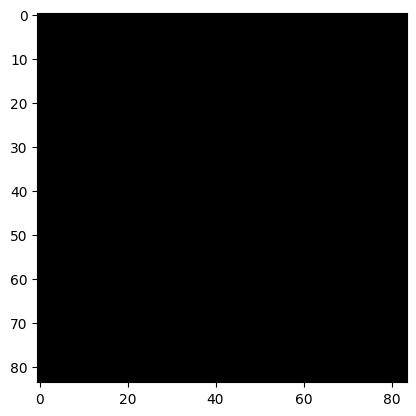

In [13]:
plt.imshow(cv2.cvtColor(obs, cv2.COLOR_BGR2RGB))

## This is what we are feeding into model^

# Hyperparameter Tune

https://pytorch.org/get-started/locally/  <- use this site to download pytorch

In [21]:
%pip install torch torchvision torchaudio


[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
%pip install stable-baselines3

  Obtaining dependency information for stable-baselines3 from https://files.pythonhosted.org/packages/06/6a/c3098a78a63b5a48e18c11d80b8c532f8b7785d6abb1329cfe3034572161/stable_baselines3-2.3.2-py3-none-any.whl.metadata
  Using cached stable_baselines3-2.3.2-py3-none-any.whl.metadata (5.1 kB)
  Obtaining dependency information for gymnasium<0.30,>=0.28.1 from https://files.pythonhosted.org/packages/a8/4d/3cbfd81ed84db450dbe73a89afcd8bc405273918415649ac6683356afe92/gymnasium-0.29.1-py3-none-any.whl.metadata
  Using cached gymnasium-0.29.1-py3-none-any.whl.metadata (10 kB)
  Obtaining dependency information for farama-notifications>=0.0.1 from https://files.pythonhosted.org/packages/05/2c/ffc08c54c05cdce6fbed2aeebc46348dbe180c6d2c541c7af7ba0aa5f5f8/Farama_Notifications-0.0.4-py3-none-any.whl.metadata
  Using cached Farama_Notifications-0.0.4-py3-none-any.whl.metadata (558 bytes)
Using cached stable_baselines3-2.3.2-py3-none-any.whl (182 kB)
Using cached gymnasium-0.29.1-py3-none-any.whl (

In [84]:
# %pip install pyglet==1.3.2

  Obtaining dependency information for pyglet==1.3.2 from https://files.pythonhosted.org/packages/1c/fc/dad5eaaab68f0c21e2f906a94ddb98175662cc5a654eee404d59554ce0fa/pyglet-1.3.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for future from https://files.pythonhosted.org/packages/da/71/ae30dadffc90b9006d77af76b393cb9dfbfc9629f339fc1574a1c52e6806/future-1.0.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.0 MB 2.6 MB/s eta 0:00:01
   -------- ------------------------------- 0.2/1.0 MB 2.5 MB/s eta 0:00:01
   -------------- ------------------------- 0.4/1.0 MB 2.9 MB/s eta 0:00:01
   ------------------- -------------------- 0.5/1.0 MB 2.9 MB/s eta 0:00:01
   ------------------------- -------------- 0.6/1.0 MB 2.7 MB/s eta 0:00:01
   ------------------------------ --------- 0.8/1.0 MB 2.9 MB/s eta 0:00:01
   ---------------------------------- ----- 0.9/1.0 MB 2.5 MB/s eta 0:


[notice] A new release of pip is available: 23.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [24]:
%pip install optuna


[notice] A new release of pip is available: 23.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [63]:
# Importing the optimzation frame - HPO
import optuna
# PPO algo for RL
from stable_baselines3 import PPO
# Bring in the eval policy method for metric calculation
from stable_baselines3.common.evaluation import evaluate_policy
# Import the sb3 monitor for logging 
from stable_baselines3.common.monitor import Monitor
# Import the vec wrappers to vectorize and frame stack
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack
# Import os to deal with filepaths
import os

In [64]:
LOG_DIR = './logs/'
OPT_DIR = './opt/'

In [62]:
# Function to return test hyperparameters - define the object function
def optimize_ppo(trial): 
    return {
        'n_steps':trial.suggest_int('n_steps', 2048, 8192), # number of frames used in one batch of training (must use a factor of 64) (maybe take a number and multiply it by 64? 😎🤝😈)
        'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999), # discount rate
        'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4), # how fast we tune optimizer (Critic and Actor for PPO)
        'clip_range':trial.suggest_uniform('clip_range', 0.1, 0.4), # how far we want to clip for our advantage value in PPO
        'gae_lambda':trial.suggest_uniform('gae_lambda', 0.8, 0.99) # smoothing parameter (used when calculating advantage)
    }

# IF U WANT TO USE OTHER ALGOS THE HYPERPARAMS MUST BE SWITCHED AS WELL (DQN, SAC, etc.)

In [145]:
# alternative version to use later to bypass factor 64 error



# # PPO optimization parameters

# PPO_PARAMS = {

#     'n_steps_range': (2048, 8192),

#     'gamma_range': (0.8, 0.9999),

#     'learning_rate_range': (1e-5, 1e-4),

#     'clip_range_range': (0.1, 0.4),

#     'gae_lambda_range': (0.8, 0.99),

# }

# # Define the optimization function for PPO

# def optimize_ppo(trial): 

#     n_steps = trial.suggest_categorical('n_steps', range(PPO_PARAMS['n_steps_range'][0], PPO_PARAMS['n_steps_range'][1], 64))  # Steps of 64

#     return {

#         'n_steps': n_steps,

#         'gamma': trial.suggest_loguniform('gamma', *PPO_PARAMS['gamma_range']),

#         'learning_rate': trial.suggest_loguniform('learning_rate', *PPO_PARAMS['learning_rate_range']),

#         'clip_range': trial.suggest_uniform('clip_range', *PPO_PARAMS['clip_range_range']),

#         'gae_lambda': trial.suggest_uniform('gae_lambda', *PPO_PARAMS['gae_lambda_range']),

#     }

In [66]:
SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(1))

In [65]:
# Run a training loop and return mean reward 
def optimize_agent(trial):
    # try:
        model_params = optimize_ppo(trial)  # get dict of hyperparams

        # Create environment 
        env = StreetFighter()
        env = Monitor(env, LOG_DIR) # allowd for logging mean episode reward and mean episode length
        env = DummyVecEnv([lambda: env])
        env = VecFrameStack(env, 4, channels_order='last')

        # Create algo 
        model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=0, **model_params) # uses model params dict
        model.learn(total_timesteps=10000) # 100000 for production model (longer if can)

        # Evaluate model 
        mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1) # 5 different games usually but went lower cuz i dont got cuda (those who know)
        env.close()

        SAVE_PATH = os.path.join(OPT_DIR, 'trial_{}_best_model'.format(trial.number))
        model.save(SAVE_PATH)

        return mean_reward

    # except Exception as e: # used in case hyperparam throws error (allows to continue training)
    #     return -1000

In [69]:
# Creating the experiment 
study = optuna.create_study(direction='maximize') # since mean reward is positive we maximize, otherwise minimize
study.optimize(optimize_agent, n_trials=1, n_jobs=1) # for prod used n_trials=100

[I 2024-11-04 00:21:22,524] A new study created in memory with name: no-name-75b592f5-3a58-44ac-9aec-20831c7c628e
/var/folders/d4/_v_lx6gx66z8htqrwxr89lvc0000gn/T/ipykernel_86005/3706438210.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma':trial.suggest_loguniform('gamma', 0.8, 0.9999), # discount rate
/var/folders/d4/_v_lx6gx66z8htqrwxr89lvc0000gn/T/ipykernel_86005/3706438210.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate':trial.suggest_loguniform('learning_rate', 1e-5, 1e-4), # how fast we tune optimizer (Critic and Actor for PPO)
/var/folders/d4/_v_lx6gx66z8htqrwxr89lvc0000gn/T/ipykernel_86005/3706438210.py:7: FutureWarning: suggest_unif

RuntimeError: Cannot create multiple emulator instances per process, make sure to call env.close() on each environment before creating a new one

In [74]:
study.best_params

{'n_steps': 7717,
 'gamma': 0.8951474854534238,
 'learning_rate': 1.5173785862671653e-05,
 'clip_range': 0.13355095227019517,
 'gae_lambda': 0.9181855173148512}

In [75]:
study.best_trial

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[2000.0], datetime_start=datetime.datetime(2024, 10, 22, 1, 12, 54, 242354), datetime_complete=datetime.datetime(2024, 10, 22, 1, 14, 56, 805445), params={'n_steps': 7717, 'gamma': 0.8951474854534238, 'learning_rate': 1.5173785862671653e-05, 'clip_range': 0.13355095227019517, 'gae_lambda': 0.9181855173148512}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_steps': IntDistribution(high=8192, log=False, low=2048, step=1), 'gamma': FloatDistribution(high=0.9999, log=True, low=0.8, step=None), 'learning_rate': FloatDistribution(high=0.0001, log=True, low=1e-05, step=None), 'clip_range': FloatDistribution(high=0.4, log=False, low=0.1, step=None), 'gae_lambda': FloatDistribution(high=0.99, log=False, low=0.8, step=None)}, trial_id=0, value=None)

In [70]:
model = PPO.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))

FileNotFoundError: [Errno 2] No such file or directory: 'opt/trial_0_best_model.zip.zip'

# Setup Callback

In [72]:
# Import base callback 
from stable_baselines3.common.callbacks import BaseCallback

In [73]:
class TrainAndLoggingCallback(BaseCallback): # continuously learn by starting from best parameters done above

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [74]:
CHECKPOINT_DIR = './train/'

In [75]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

# Train Model

In [76]:
# Create environment 
env = StreetFighter()
env = Monitor(env, LOG_DIR)
env = DummyVecEnv([lambda: env])
env = VecFrameStack(env, 4, channels_order='last')

AssertionError: VecFrameStack only works with gym.spaces.Box and gym.spaces.Dict observation spaces

In [77]:
model_params = study.best_params
model_params['n_steps'] = 7488  # set n_steps to 7488 or a factor of 64
# model_params['learning_rate'] = 5e-7 -> if really slow at training
model_params

ValueError: No trials are completed yet.

In [78]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, **model_params) # verbose 1 shows results as training

NameError: name 'model_params' is not defined

In [79]:
# Reload previous weights from HPO
model.load(os.path.join(OPT_DIR, 'trial_0_best_model.zip'))

NameError: name 'model' is not defined

In [80]:
# Kick off training 
model.learn(total_timesteps=5000, callback=callback) # timestep 5000000 recommended

NameError: name 'model' is not defined

In [45]:
# tensorboard --logdir=. 
# cd to logs
# ^ use to visually see learning progress

# Evaluate Model

In [24]:
model = PPO.load('./train/best_model_7000.zip')

d:\StreetFighterRL\env_3\lib\site-packages\stable_baselines3\common\save_util.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_loc

In [25]:
mean_reward, _ = evaluate_policy(model, env, render=True, n_eval_episodes=1)

d:\StreetFighterRL\env_3\lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")


In [26]:
mean_reward

5900.0

# Testing Model

In [ ]:
obs = env.reset()

In [ ]:
obs.shape

In [ ]:
env.step(model.predict(obs)[0])

In [ ]:
# Reset game to starting state
obs = env.reset()
# Set flag to flase
done = False
for game in range(1): 
    while not done: 
        if done: 
            obs = env.reset()
        env.render()
        action = model.predict(obs)[0]
        obs, reward, done, info = env.step(action)
        time.sleep(0.01)
        print(reward)

## Mucking aboyt.213213231112331

In [72]:
env.close()

In [27]:
env = StreetFighter()
print(env.observation_space)

Box([[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]], [[[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 ...

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]

 [[255]
  [255]
  [255]
  ...
  [255]
  [255]
  [255]]], (84, 84, 1), uint8)


In [ ]:
# pip list

In [ ]:
# was on protobuf 5.28.2

In [ ]:
# please note that pyglet 1.3.2 was for tensorboard, the rendering was for newesrt version